In [1]:
##import packages to be used in this session
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

Unlike the previous attempts, this analysis will use a modified data set which includes 15 additional variables added from the County Rankings and Roadmaps database. This modification was made to see how the model performance changes with additional features. Note that these variables are similar to previous ones in that they provide additional descriptions of the social, environmental, and economic charactersitic of counties. Below is a list of the new variables along with their shortened variable names used in the analysis: 

1. "High school graduation raw value":"high_sch_grad",
2. "Some college raw value":"some_college",
3. "Social associations raw value":"soc_association",
4. "Percentage of households with high housing costs":"perc_high_cost",
5. "Percentage of households with overcrowding":"perc_overcrowding",
6. "Percentage of households with lack of kitchen or plumbing facilities":"perc_plumb",
7. "Long commute - driving alone raw value":"lng_commute",
8. "Life expectancy raw value":"life_exp",
9. "Premature age-adjusted mortality raw value":"pre_mortality",
10. "Frequent physical distress raw value":"phys_distress",
11. "Frequent mental distress raw value":"ment_distress",
12. "Diabetes prevalence raw value":"diab_prevalence",
13. "Food insecurity raw value":"food_insecure",
14. "Limited access to healthy foods raw value":"food_access",
15. "% Rural raw value":"perc_rural"

In [2]:
##import project csv file
df=pd.read_csv("Data/COVID_project_PPOL564_v2.csv")

In [3]:
##print shape
df.shape

(974, 46)

In [5]:
##view first 10 observations
df.head(10)

,fips,state,county,cases,white_cases,black_cases,hispanic_cases,native_cases,asian_cases,TOT_POP,...,perc_plumb,lng_commute,life_exp,pre_mortality,phys_distress,ment_distress,diab_prevalence,food_insecure,food_access,perc_rural
0,1001,AL,Autauga County,119,44,21,0,0,0,55869,...,0.013462,0.396,76.879477,417.547551,0.136852,0.141293,0.111,0.132,0.119911,0.420022
1,1003,AL,Baldwin County,201,144,6,0,0,0,223234,...,0.004790,0.417,78.450258,353.343111,0.124801,0.134753,0.107,0.116,0.054244,0.422791
2,1005,AL,Barbour County,91,5,32,0,0,0,24686,...,0.006031,0.322,75.341935,497.350062,0.171849,0.165863,0.176,0.220,0.107397,0.677896
3,1007,AL,Bibb County,50,17,5,0,0,0,22394,...,0.007092,0.498,73.571820,589.041117,0.136266,0.140175,0.145,0.143,0.026016,0.683526
4,1009,AL,Blount County,37,15,0,0,0,0,57826,...,0.010912,0.594,74.145826,515.611823,0.145232,0.148593,0.170,0.107,0.028801,0.899515
5,1011,AL,Bullock County,125,0,106,0,0,0,10101,...,0.030942,0.460,73.530895,562.247530,0.168810,0.158548,0.237,0.248,0.197434,0.513744
6,1013,AL,Butler County,263,65,166,0,0,0,19448,...,0.003909,0.323,72.918309,609.169707,0.166967,0.169154,0.192,0.206,0.029261,0.712322
7,1015,AL,Calhoun County,124,72,23,0,0,0,113605,...,0.008431,0.312,73.039109,574.563842,0.147544,0.151915,0.175,0.157,0.091786,0.336968
8,1017,AL,Chambers County,301,81,181,0,0,0,33254,...,0.009386,0.318,74.291076,511.626517,0.152478,0.154967,0.199,0.179,0.103286,0.491480
9,1021,AL,Chilton County,65,27,0,0,0,0,44428,...,0.008123,0.503,74.926751,519.630806,0.145910,0.151771,0.186,0.131,0.014605,0.867447


We'll start by examining the data types and making adjustments to prepare for visualization and take notes for high-level pre-processing.

In [6]:
##check data types
df.dtypes

fips                   int64
state                 object
county                object
cases                  int64
white_cases            int64
black_cases            int64
hispanic_cases         int64
native_cases           int64
asian_cases            int64
TOT_POP                int64
WH                     int64
BA                     int64
AA                     int64
IA                     int64
HI                     int64
GDP                  float64
pov_perc             float64
Med_inc               object
Unemployment Rate    float64
traffic_vol          float64
house_burden         float64
ownership            float64
residential_seg      float64
food_index           float64
pop_to_phys          float64
water_violation      float64
air_pollution        float64
uninsured            float64
exercise_opp         float64
income_ineq          float64
crime_violent        float64
high_sch_grad        float64
some_college         float64
soc_association      float64
perc_high_cost

Let's convert 'Med_inc'(median household income) to a numeric data type as it is currently object/string data type. Let's also convert 'water_violation' to a categorical data type: this is a binary variable which takes on a value of either 0 or 1 to indicate if a water violation has been reported in the county. 

In [7]:
## remove commas from Med_inc column
df['Med_inc']=df['Med_inc'].str.replace(",","")
##change 'Med_inc' to dtype integer
df['Med_inc']=df['Med_inc'].astype('int')

In [8]:
## change 'water_violation' to dtype category
df['water_violation']=df['water_violation'].astype('category')

Now, we'll look at missingness in our data. This will determine if observations need to be removed; if imputation needs to be considered; or if observations need to be subsetted. 

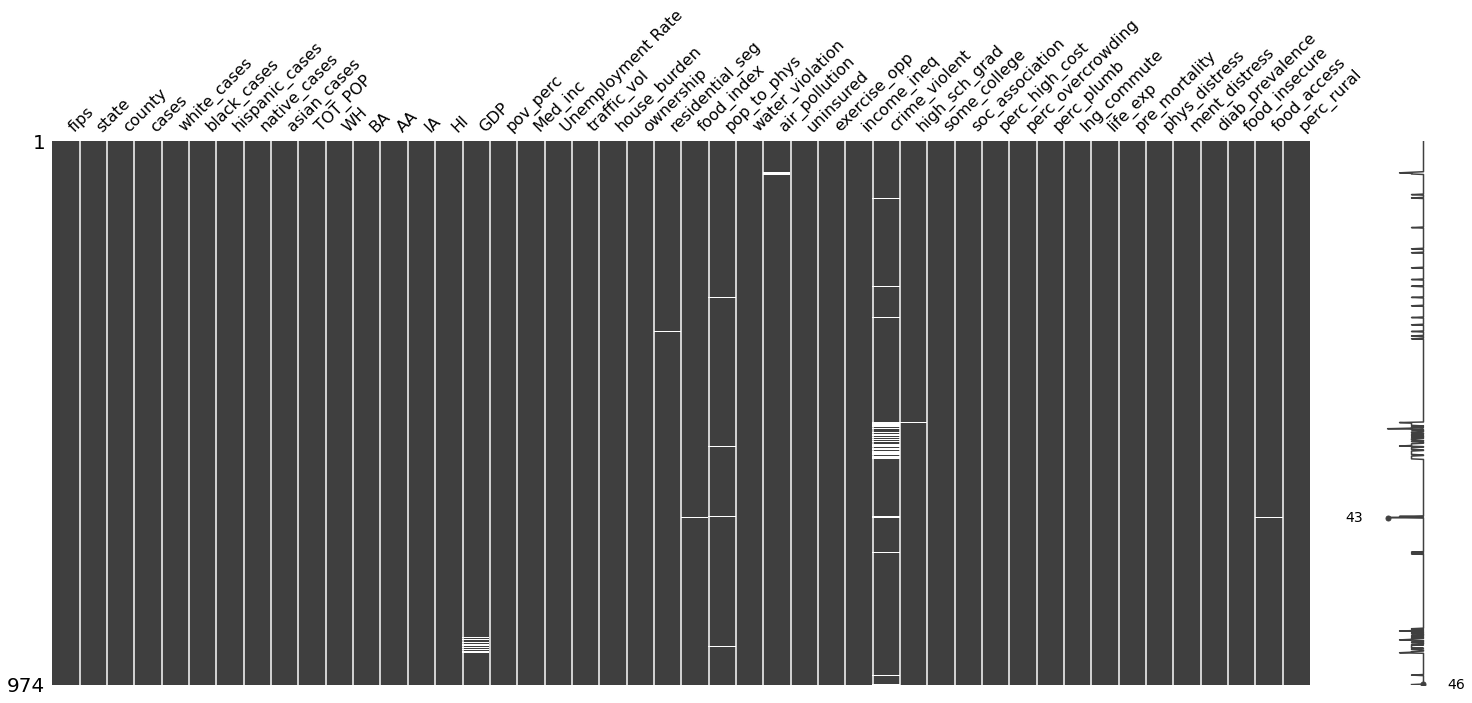

In [9]:
## examine missingness 
miss.matrix(df) 

Looking at the plot above, a couple of the feature variables stand out as having missing values: 'GDP' and 'crime_violent' seem to having the most missing observations, closely followed by 'residential_seg','food_index','pop_to_phys','water_violation', 'air_pollution', and 'food_access'. Next, a numeric description of missingness will be generated to see the extent of missingness and determine how best to deal with missing values. 

In [10]:
##numeric visualization of missingness 
df.isnull().sum()

fips                  0
state                 0
county                0
cases                 0
white_cases           0
black_cases           0
hispanic_cases        0
native_cases          0
asian_cases           0
TOT_POP               0
WH                    0
BA                    0
AA                    0
IA                    0
HI                    0
GDP                  19
pov_perc              0
Med_inc               0
Unemployment Rate     0
traffic_vol           0
house_burden          0
ownership             0
residential_seg       2
food_index            4
pop_to_phys           9
water_violation       1
air_pollution         4
uninsured             0
exercise_opp          0
income_ineq           0
crime_violent        56
high_sch_grad         1
some_college          0
soc_association       0
perc_high_cost        0
perc_overcrowding     0
perc_plumb            0
lng_commute           0
life_exp              0
pre_mortality         0
phys_distress         0
ment_distress   

The variable 'crime_violent' has the largest number of missing values.Although a case was made for removing this variable in the first attempt, the second attempt showed that this variable is somewhat important to the model when making decisions. So it will be included in this attempt also. Since the other features with missing values might have an interesting relationship with the outcome variable, these variables will be included in the modeling process and all observations missing values for any of the 46 feature variables will be removed. 

In [11]:
##create modified dataframe 
df2=df
## check shape
df2.shape

(974, 46)

In [12]:
## remove observations with NAs for all feature variabels 
df2= df2.dropna()

In [13]:
##double check missingness 
df2.isnull().sum()

fips                 0
state                0
county               0
cases                0
white_cases          0
black_cases          0
hispanic_cases       0
native_cases         0
asian_cases          0
TOT_POP              0
WH                   0
BA                   0
AA                   0
IA                   0
HI                   0
GDP                  0
pov_perc             0
Med_inc              0
Unemployment Rate    0
traffic_vol          0
house_burden         0
ownership            0
residential_seg      0
food_index           0
pop_to_phys          0
water_violation      0
air_pollution        0
uninsured            0
exercise_opp         0
income_ineq          0
crime_violent        0
high_sch_grad        0
some_college         0
soc_association      0
perc_high_cost       0
perc_overcrowding    0
perc_plumb           0
lng_commute          0
life_exp             0
pre_mortality        0
phys_distress        0
ment_distress        0
diab_prevalence      0
food_insecu

In [14]:
##check shape
df2.shape

(885, 46)

Before we begin exploring this data, we need to split it into a training and test dataset. Since the outcome variable has not been generated just yet, we will start by creating the outcome variable, then the data will be split into training and test.

### Step 1: Create Outcome Variable
The goal of this project is to examine the factors that lead to racial and ethnic health disparities among racial and ethnic minority population in COVID-19 cases. The outcome variable will be generated by: 
1. Calculating the COVID-19 percentage share by race and ethnicity for each county
2. Calculating the racial/ethnic distribution of populations for each county
3. Subtracting the COVID-19 case percentage from the population percentage for each race/ethnicity in each county. If the value is positive, it is indicative of a disparity in COVID-19 cases for that race/ethnicity; if the value is equal to 0, the COVID-19 cases for that race/ethnicity is the same as their population; lastly, if the value is negative, the COVID-19 cases for that race/ethnicity is less than their share of the population. This disparity metric calculation was taken from the CDC: https://www.cdc.gov/nchs/nvss/vsrr/covid19/health_disparities.htm. 

**NOTE: Unlike the first attempt, the outcome variable will be a measure of disparity only for the Black population. This decision is motivated by the results from the previous model as well as literature on disparity research which notes that the influence of/experience with
the county characteristics used in these models will vary for different racial/ethnic groups.**

#### 1. Calculating the COVID-19 percentage share by race and ethnicity for each county

In [15]:
##calculate percentage share of black cases out of  total cases
df2['cases_min_pop']=df2['black_cases']/df2['cases']

#### 2. Calculating the racial/ethnic distribution of populations for each county

In [16]:
##calculate percentage of black population out of total population 
df2['min_pop']=df2['BA']/df2['TOT_POP']

#### 3. Subtracting the COVID-19 case percentage from the population percentage for each race/ethnicity in each county.

In [17]:
##create disparity index
df2['disp_index']=df2['cases_min_pop']-df2['min_pop']
##multiply by 100
df2['disp_index'] = df2['disp_index'].apply(lambda x: x*10)

In [18]:
##check dtype
df2.disp_index.dtypes

dtype('float64')

### Step 2: Separate into training and test data sets

In [19]:
## isolate outcome from features
y = df2[['disp_index']]
X = df2.drop(columns=['disp_index'])

In [20]:
## split in to training (75% of data) and test (25% of data); set random state to replicate same split every time
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [21]:
##check shape to confirm split
print(train_X.shape[0]/df2.shape[0])
print(test_X.shape[0]/df2.shape[0])

0.7491525423728813
0.25084745762711863


### Step 3: Explore training dataset

In [22]:
##view first 20 observations
train_X.head(20)

,fips,state,county,cases,white_cases,black_cases,hispanic_cases,native_cases,asian_cases,TOT_POP,...,life_exp,pre_mortality,phys_distress,ment_distress,diab_prevalence,food_insecure,food_access,perc_rural,cases_min_pop,min_pop
185,13037,GA,Calhoun County,45,0,5,0,0,0,6189,...,76.936391,516.416267,0.150890,0.148147,0.188,0.224,0.056939,1.000000,0.111111,0.608499
913,51187,VA,Warren County,121,68,0,0,0,0,40164,...,76.571859,408.915289,0.101813,0.113303,0.154,0.080,0.031224,0.504085,0.000000,0.049622
83,5071,AR,Johnson County,31,5,0,0,0,0,26578,...,76.033192,463.319842,0.143246,0.149598,0.129,0.154,0.029038,0.713665,0.000000,0.021935
932,53067,WA,Thurston County,107,53,0,0,0,0,290536,...,80.329402,285.445973,0.107220,0.115793,0.103,0.123,0.069904,0.209887,0.000000,0.035944
251,17027,IL,Clinton County,158,93,0,0,0,0,37562,...,79.655178,304.438222,0.095350,0.109248,0.132,0.083,0.048397,0.487580,0.000000,0.036633
211,13151,GA,Henry County,401,23,42,0,0,0,234561,...,77.427661,363.980506,0.104730,0.116888,0.130,0.137,0.095248,0.138533,0.104738,0.483810
695,37135,NC,Orange County,308,116,68,15,0,0,148476,...,82.086503,230.673166,0.112521,0.116560,0.058,0.127,0.089198,0.285319,0.220779,0.117777
313,19095,IA,Iowa County,16,5,0,0,0,0,16184,...,79.818163,296.793792,0.090922,0.104984,0.097,0.098,0.032843,0.821828,0.000000,0.007785
240,16031,ID,Cassia County,39,5,0,0,0,0,24030,...,77.621404,376.743390,0.113091,0.119477,0.115,0.097,0.122305,0.515119,0.000000,0.008739
50,1123,AL,Tallapoosa County,341,185,119,0,0,0,40367,...,74.530869,497.482388,0.145153,0.153077,0.159,0.166,0.043250,0.742263,0.348974,0.270047


__What is the distribution of the feature variables?__

Check the distribution of all continious variables coded with dtype 'int'.

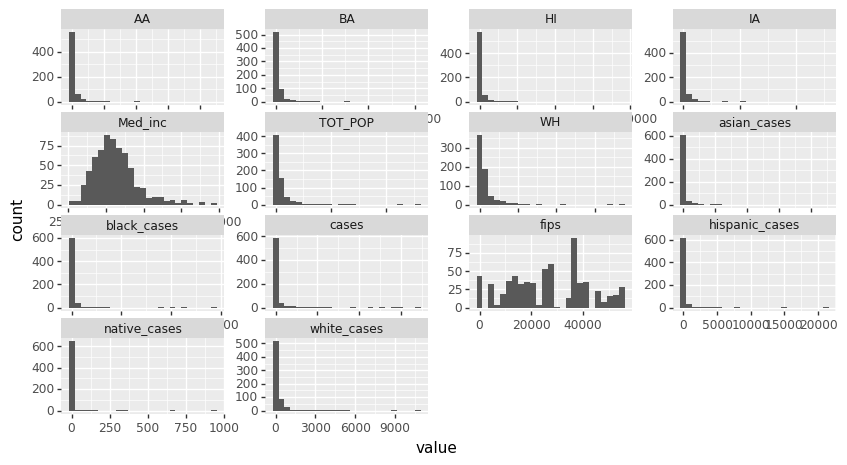

<ggplot: (8773348840587)>

In [23]:
## view continous int variables
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

The 'fips' variable will not be included in the model. Apart from the median income variable ('Med_inc'), the rest of the variables have a right skew. These variables represent a county's population and a county's COVID-19 cases by racial and ethnic groups. Let's log these variables and see how their distribution changes

In [24]:
## check if any of the variables have a value of 0 before taking their log
print((train_X == 0).sum())

fips                   0
state                  0
county                 0
cases                  0
white_cases           44
black_cases          326
hispanic_cases       410
native_cases         633
asian_cases          556
TOT_POP                0
WH                     0
BA                     0
AA                     0
IA                     0
HI                     0
GDP                    0
pov_perc               0
Med_inc                0
Unemployment Rate      0
traffic_vol            0
house_burden           0
ownership              0
residential_seg        0
food_index             0
pop_to_phys            0
water_violation      391
air_pollution          0
uninsured              0
exercise_opp           1
income_ineq            0
crime_violent          0
high_sch_grad          0
some_college           0
soc_association        2
perc_high_cost         0
perc_overcrowding      0
perc_plumb             0
lng_commute            0
life_exp               0
pre_mortality          0


Variables to add 1 to when logging: white_cases, black_cases, hispanic_cases, native_cases, asian_cases, water_violation, exercise_opp, soc_association, food_access, and perc_rural. Note that cases_min_pop represents the share of black cases.It was generated to create the outcome variable; it will not be included in the model. 

In [25]:
## check min value to confirm absence of negative values before taking the log of any of the variables
print(train_X.min())

fips                            1001
state                             AL
county               Accomack County
cases                              5
white_cases                        0
black_cases                        0
hispanic_cases                     0
native_cases                       0
asian_cases                        0
TOT_POP                         4736
WH                               933
BA                                44
AA                                11
IA                                 9
HI                                63
GDP                           118542
pov_perc                         4.2
Med_inc                        26814
Unemployment Rate                1.6
traffic_vol                  3.93745
house_burden               0.0509467
ownership                   0.196073
residential_seg              4.13169
food_index                         2
pop_to_phys                  440.142
water_violation                    0
air_pollution                    3.4
u

In [26]:
##log variables
d = train_X.copy()
d['ln_AA'] =  np.log(d['AA'] )
d['ln_BA'] =  np.log(d['BA'])
d['ln_IA'] =  np.log(d['IA'] )
d['ln_HI'] =  np.log(d['HI'])
d['ln_WH'] =  np.log(d['WH'] )
d['ln_TOT_POP'] =  np.log(d['TOT_POP'])
d['ln_cases'] =  np.log(d['cases'] )
d['ln_AAcases'] =  np.log(d['asian_cases'] + 1)## add 1 to avoid loggin 0s
d['ln_BAcases'] =  np.log(d['black_cases'] + 1)## add 1 to avoid loggin 0s
d['ln_IAcases'] =  np.log(d['native_cases'] + 1)## add 1 to avoid loggin 0s
d['ln_HIcases'] =  np.log(d['hispanic_cases'] + 1)## add 1 to avoid loggin 0s
d['ln_WHcases'] =  np.log(d['white_cases'] + 1)## add 1 to avoid loggin 0s


In [27]:
##keep only logged variables
d=d.loc[:, d.columns.str.startswith('ln')]
##transform from wide to long for visualization
d=d.melt()

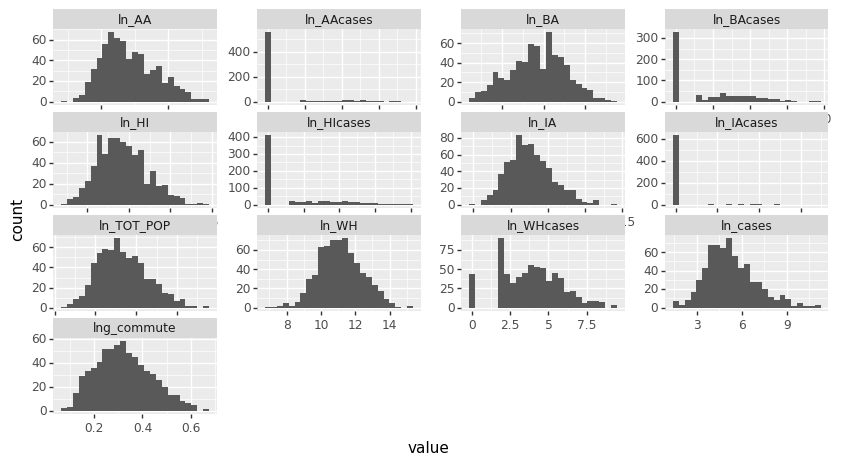

<ggplot: (8773348845457)>

In [28]:
##visualize
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

While logging seems to have normalized the distribution of the population variables, the racial and ethnic breakdown of COVID-19 cases has not normalized. Just like attempt #2, We will bin these variables in the pre-processing stage. 

Next, let us visualize the continious variables with dtype=float.

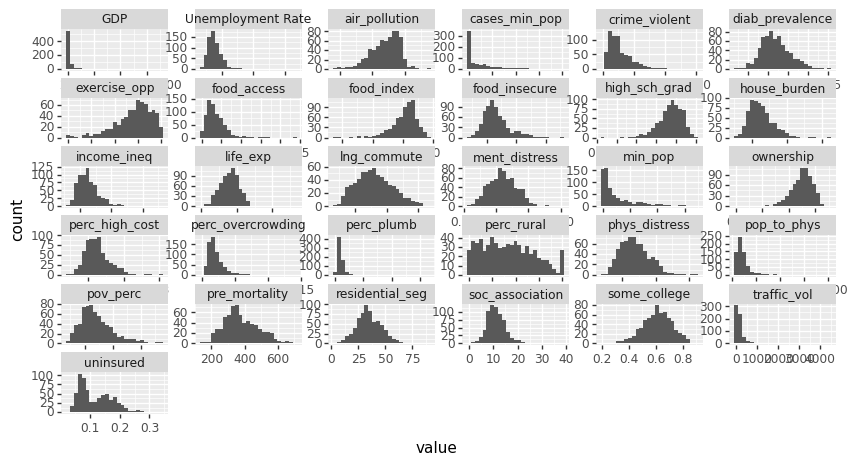

<ggplot: (8773347618422)>

In [29]:
## view continious float variables
e = train_X.select_dtypes(include="float").melt()
(
    ggplot(e,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

The variables min_pop and cases_min_pop will not be included in the model since they were generated to create the outcome variable. GDP, Unemployment Rate, ownership, pop_to_phys, crime_violent, perc_plumb, perc_overcrowding, food_index, and traffic volume seem to have a pronounced skew. Let us log these variables and see how they look: 
    

In [30]:
##log variables
d = train_X.copy()
d['ln_GDP'] =  np.log(d['GDP'] )
d['ln_Unemployment Rate'] =  np.log(d['Unemployment Rate'] )
d['ln_ownership'] =  np.log(d['ownership'] )
d['ln_pop_to_phys'] =  np.log(d['pop_to_phys'] )
d['ln_traffic_vol'] =  np.log(d['traffic_vol'] )
d['ln_perc_plumb'] =  np.log(d['perc_plumb'] )
d['ln_perc_overcrowding'] =  np.log(d['perc_overcrowding'] )
d['ln_food_index'] =  np.log(d['food_index'] )
d['ln_crime_violent'] =  np.log(d['crime_violent'] )

In [31]:
##keep only logged variables
d=d.loc[:, d.columns.str.startswith('ln')]
##transform from wide to long for visualization
d=d.melt()

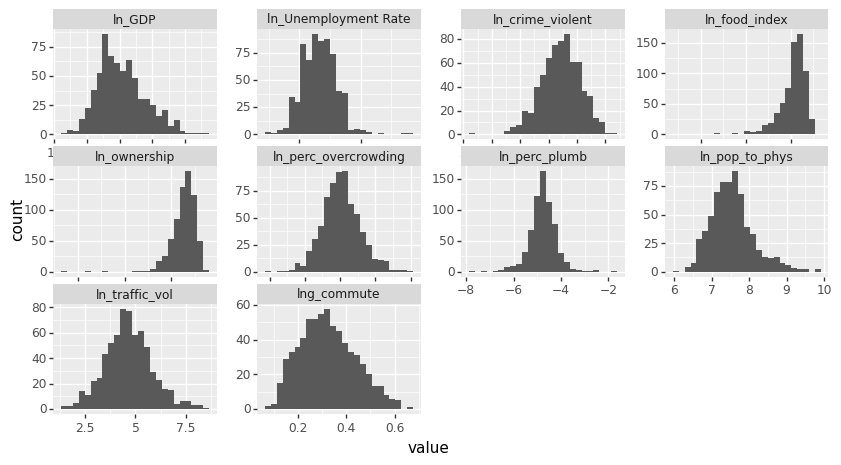

<ggplot: (8773350722160)>

In [32]:
##visualize
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

Logging seems to have normalized most of the variables, however, the variables 'ownership' and 'food_index' have not benefitted from logging. They will be turned into categorical varaibles in the high-level preprocessing stage. Note that in attempt #2, ownership was not binned to retain information. Since this attempt has more variables that may provide additional predictive power compared to the data set from attempt 2, ownership will be binned.

Now let us look at the distribution of the only categorical variable. Based on the data source, "1 means “Yes” and indicates that at least one community water system in the county received at least one health-based violation during the specified time frame. 0 means “No” and indicates that there were no health-based drinking water violations in any community drinking water system in the county."https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-factors/physical-environment/air-water-quality/drinking-water-violations



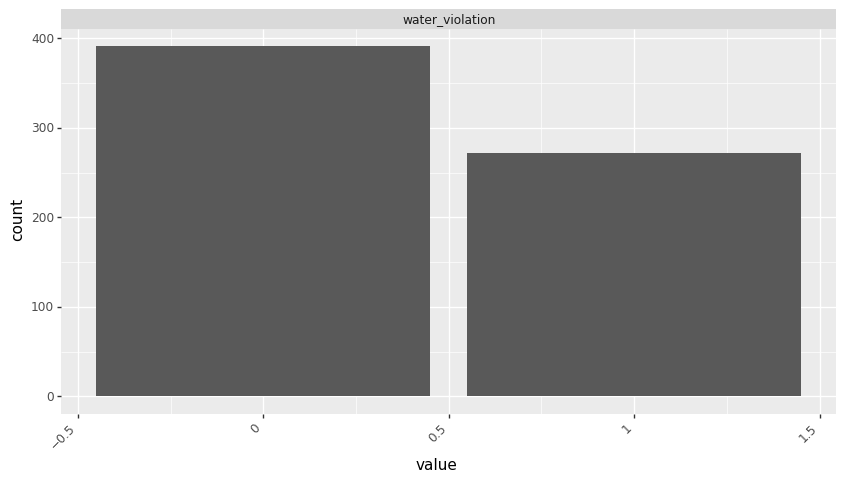

<ggplot: (8773350763409)>

In [33]:
##categorical variables
f = train_X.select_dtypes(include="category").melt()
(
    ggplot(f,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

Majority of the counties in the training data set have not recieved a health-based drinking water violation in 2018. Conversely, over 200 counties have recieved a  health-based drinking water violation in 2018.

__What is the distribution of the outcome variable?__

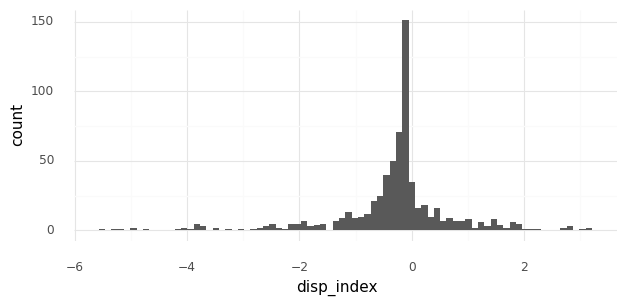

<ggplot: (8773348635525)>

In [34]:
##distribution of outcome variable
(
    ggplot(train_y,
           aes(x="disp_index")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

Similar to attempt 1, it appears that, for majority of the counties represented in the training data set, the disparity index has a value less than zero. There are fewer observations the are greater than 0 on the disparity index (i.e, where disparity is detected).

### Step 4:  High-level preprocessing

Similar to attempt 2,  I will log and bin variables based on the insights from the exploration of the training data above.

#### `AA`: Asian American Population

In [35]:
df2['AA'] =  np.log(df2['AA'])

#### `BA`: Black  Population

In [36]:
df2['BA'] =  np.log(df2['BA'])

#### `IA`: Native American Population

In [37]:
df2['IA'] =  np.log(df2['IA'])

#### `HI`: Hispanic  Population

In [38]:
df2['HI'] =  np.log(df2['HI'])

#### `WH`: White Population

In [39]:
df2['WH'] =  np.log(df2['WH'])

#### `TOT_POP`: Total County Population

In [40]:
df2['TOT_POP'] =  np.log(df2['TOT_POP'])

#### `cases`: County-Level Total COVID-19 Cases

In [41]:
df2['cases'] =  np.log(df2['cases'])

#### `asian_cases`: County-Level Asian American COVID-19 Cases

In [42]:
## categorize : 0 if value is 0; 1 if less than or equal to the median; and 2 if greater than the median
median_aacases= df2.loc[df2['asian_cases'] > 0,'asian_cases'].median()
df2['asian_cases'] =np.where(df2['asian_cases']==0,0,np.where(df2['asian_cases'] <= median_aacases,1,2))

In [43]:
## check categories
df2.asian_cases.value_counts()

0    740
1     73
2     72
Name: asian_cases, dtype: int64

#### `black_cases`: County-Level Black COVID-19 Cases

In [44]:
## categorize : 0 if value is 0; 1 if less than or equal to the median; and 2 if greater than the median
median_bacases= df2.loc[df2['black_cases'] > 0,'black_cases'].median()
df2['black_cases'] =  np.where(df2['black_cases']==0,0,np.where(df2['black_cases'] <= median_bacases,1,2))

In [45]:
## check categories
df2.black_cases.value_counts()

0    436
1    227
2    222
Name: black_cases, dtype: int64

#### `native_cases`: County-Level Native American COVID-19 Cases

In [46]:
## categorize : 0 if value is 0; 1 if less than or equal to the median; and 2 if greater than the median
median_nacases= df2.loc[df2['native_cases'] > 0,'native_cases'].median()
df2['native_cases'] =  np.where(df2['native_cases']==0,0,np.where(df2['asian_cases'] <= median_nacases,1,2))

In [47]:
## check categories
df2.native_cases.value_counts()

0    848
1     37
Name: native_cases, dtype: int64

#### `hispanic_cases`: County-Level Hispanic COVID-19 Cases

In [48]:
## categorize : 0 if value is 0; 1 if less than or equal to the median; and 2 if greater than the median
median_hispcases= df2.loc[df2['hispanic_cases'] > 0,'hispanic_cases'].median()
df2['hispanic_cases'] =  np.where(df2['hispanic_cases']==0,0,np.where(df2['hispanic_cases'] <= median_hispcases,1,2))

In [49]:
## check categories
df2.hispanic_cases.value_counts()

0    542
1    172
2    171
Name: hispanic_cases, dtype: int64

#### `white_cases`: County-Level White COVID-19 Cases

In [50]:
## categorize : 0 if value is 0; 1 if less than or equal to the median; and 2 if greater than the median
median_whcases= df2.loc[df2['asian_cases'] > 0,'white_cases'].median()
df2['white_cases'] =  np.where(df2['white_cases']==0,0,np.where(df2['white_cases'] <= median_whcases,1,2))

In [51]:
## check categories
df2.white_cases.value_counts()

1    750
2     78
0     57
Name: white_cases, dtype: int64

#### `GDP`: County-Level GDP

In [52]:
df2['GDP'] =  np.log(df2['GDP'] )

#### `Unemployment Rate`: County-Level Unemployment Rate

In [53]:
df2['Unemployment Rate'] =  np.log(df2['Unemployment Rate'])

#### `ownership`: County-Level Homeownership

In [54]:
median_ownership = df2.loc[df2['ownership'] > 0,'ownership'].median()
df2['ownership'] =  np.where(df2['ownership']==0,0,np.where(df2['ownership'] <= median_ownership,1,2))

#### `food_index`: Index of factors that contribute to a healthy food environment, from 0 (worst) to 10 (best).

In [55]:
median_food_index = df2.loc[df2['food_index'] > 0,'food_index'].median()
df2['food_index'] =  np.where(df2['food_index']==0,0,np.where(df2['food_index'] <= median_ownership,1,2))

#### `pop_to_phys`: County-Level Ration of Physician to Population

In [56]:
df2['pop_to_phys'] =  np.log(df2['pop_to_phys'])

#### `perc_overcrowding`: Percentage of households with overcrowding

In [57]:
df2['perc_overcrowding'] =  np.log(df2['perc_overcrowding'])

#### `perc_plumbing`: Percentage of households with lack of kitchen or plumbing facilities

In [58]:
df2['perc_plumb'] =  np.log(df2['perc_plumb'])

#### `traffic_vol`: County-Level Traffic Volume

In [59]:
df2['traffic_vol'] =  np.log(df2['traffic_vol'])

#### `crime_violent`: County-Level Violent Crime Rate

In [60]:
df2['crime_violent'] =  np.log(df2['crime_violent'])

### Step 5: Resplit data

In [61]:
##isolate outcome and features
y = df2[['disp_index']]
##drop irrelevant columns when isolating features from outcome
X = df2.drop(columns=['disp_index','fips','state','county','cases_min_pop','min_pop' ])

In [62]:
## split in to training (75% of data) and test (25% of data); set random state to replicate same split every time
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [63]:
##check shape to confirm split
print(train_X.shape[0]/df2.shape[0])
print(test_X.shape[0]/df2.shape[0])

0.7491525423728813
0.25084745762711863


### Step 6:  Pre-Processing

Let's rescale our training data for now, but we'll put the preprocessing into a modeling pipeline later on.

In [64]:
## scale so variables are on the same scale
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [65]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,cases,white_cases,black_cases,hispanic_cases,native_cases,asian_cases,TOT_POP,WH,BA,AA,...,perc_plumb,lng_commute,life_exp,pre_mortality,phys_distress,ment_distress,diab_prevalence,food_insecure,food_access,perc_rural
0,0.230882,0.0,0.5,0.0,0.0,0.0,0.038272,0.105389,0.434721,0.148238,...,0.277574,0.490694,0.246148,0.677677,0.566603,0.550430,0.722222,0.561514,0.120146,1.000000
1,0.334819,0.5,0.0,0.0,0.0,0.0,0.305764,0.441796,0.372548,0.365671,...,0.321882,0.818951,0.232281,0.486776,0.216325,0.248447,0.576923,0.107256,0.065885,0.504085
2,0.191722,0.5,0.0,0.0,0.0,0.0,0.246709,0.393486,0.252455,0.394330,...,0.643265,0.172589,0.211789,0.583388,0.512049,0.563008,0.470085,0.340694,0.061274,0.713665
3,0.321898,0.5,0.0,0.0,0.0,0.0,0.588783,0.667941,0.534367,0.699018,...,0.595290,0.424704,0.375222,0.267520,0.254912,0.270035,0.358974,0.242902,0.147503,0.209887
4,0.362854,0.5,0.0,0.0,0.0,0.0,0.296184,0.438293,0.336354,0.284123,...,0.458760,0.509306,0.349574,0.301246,0.170196,0.213310,0.482906,0.116719,0.102121,0.487580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0.528181,0.5,0.0,1.0,0.0,0.0,0.605341,0.693900,0.439258,0.688660,...,0.544497,0.351946,0.475648,0.125357,0.148801,0.156206,0.123932,0.208202,0.065030,0.089131
659,0.160356,0.0,0.0,0.5,0.0,0.0,0.139522,0.308745,0.117849,0.188226,...,0.571617,0.133672,0.353791,0.336747,0.208010,0.243571,0.222222,0.179811,0.047394,0.567995
660,0.433675,0.5,0.0,0.0,0.0,0.0,0.385587,0.513458,0.318314,0.442200,...,0.518766,0.483926,0.353897,0.277703,0.242953,0.298159,0.418803,0.132492,0.119913,0.544317
661,0.280270,0.5,0.5,0.0,0.0,0.0,0.266967,0.412754,0.344523,0.209959,...,0.449649,0.417936,0.183884,0.637570,0.608467,0.589135,0.431624,0.337539,0.047596,0.684339


### Step 6: Modeling

We have a continuously distributed outcome variable i.e., a regression problem.Let's test how these models perform

- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest

In [66]:
## set fold generator to split and test on same data across models
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

Let's run each model individually then compare the performance of the different models in a plot.

We'll use **mean squared error** as our performance metrics.

In [67]:
## performance metric
use_metrics = ["neg_mean_squared_error"]

#### Linear Model

In [68]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### KNN

In [69]:
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Decision Tree

In [70]:
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

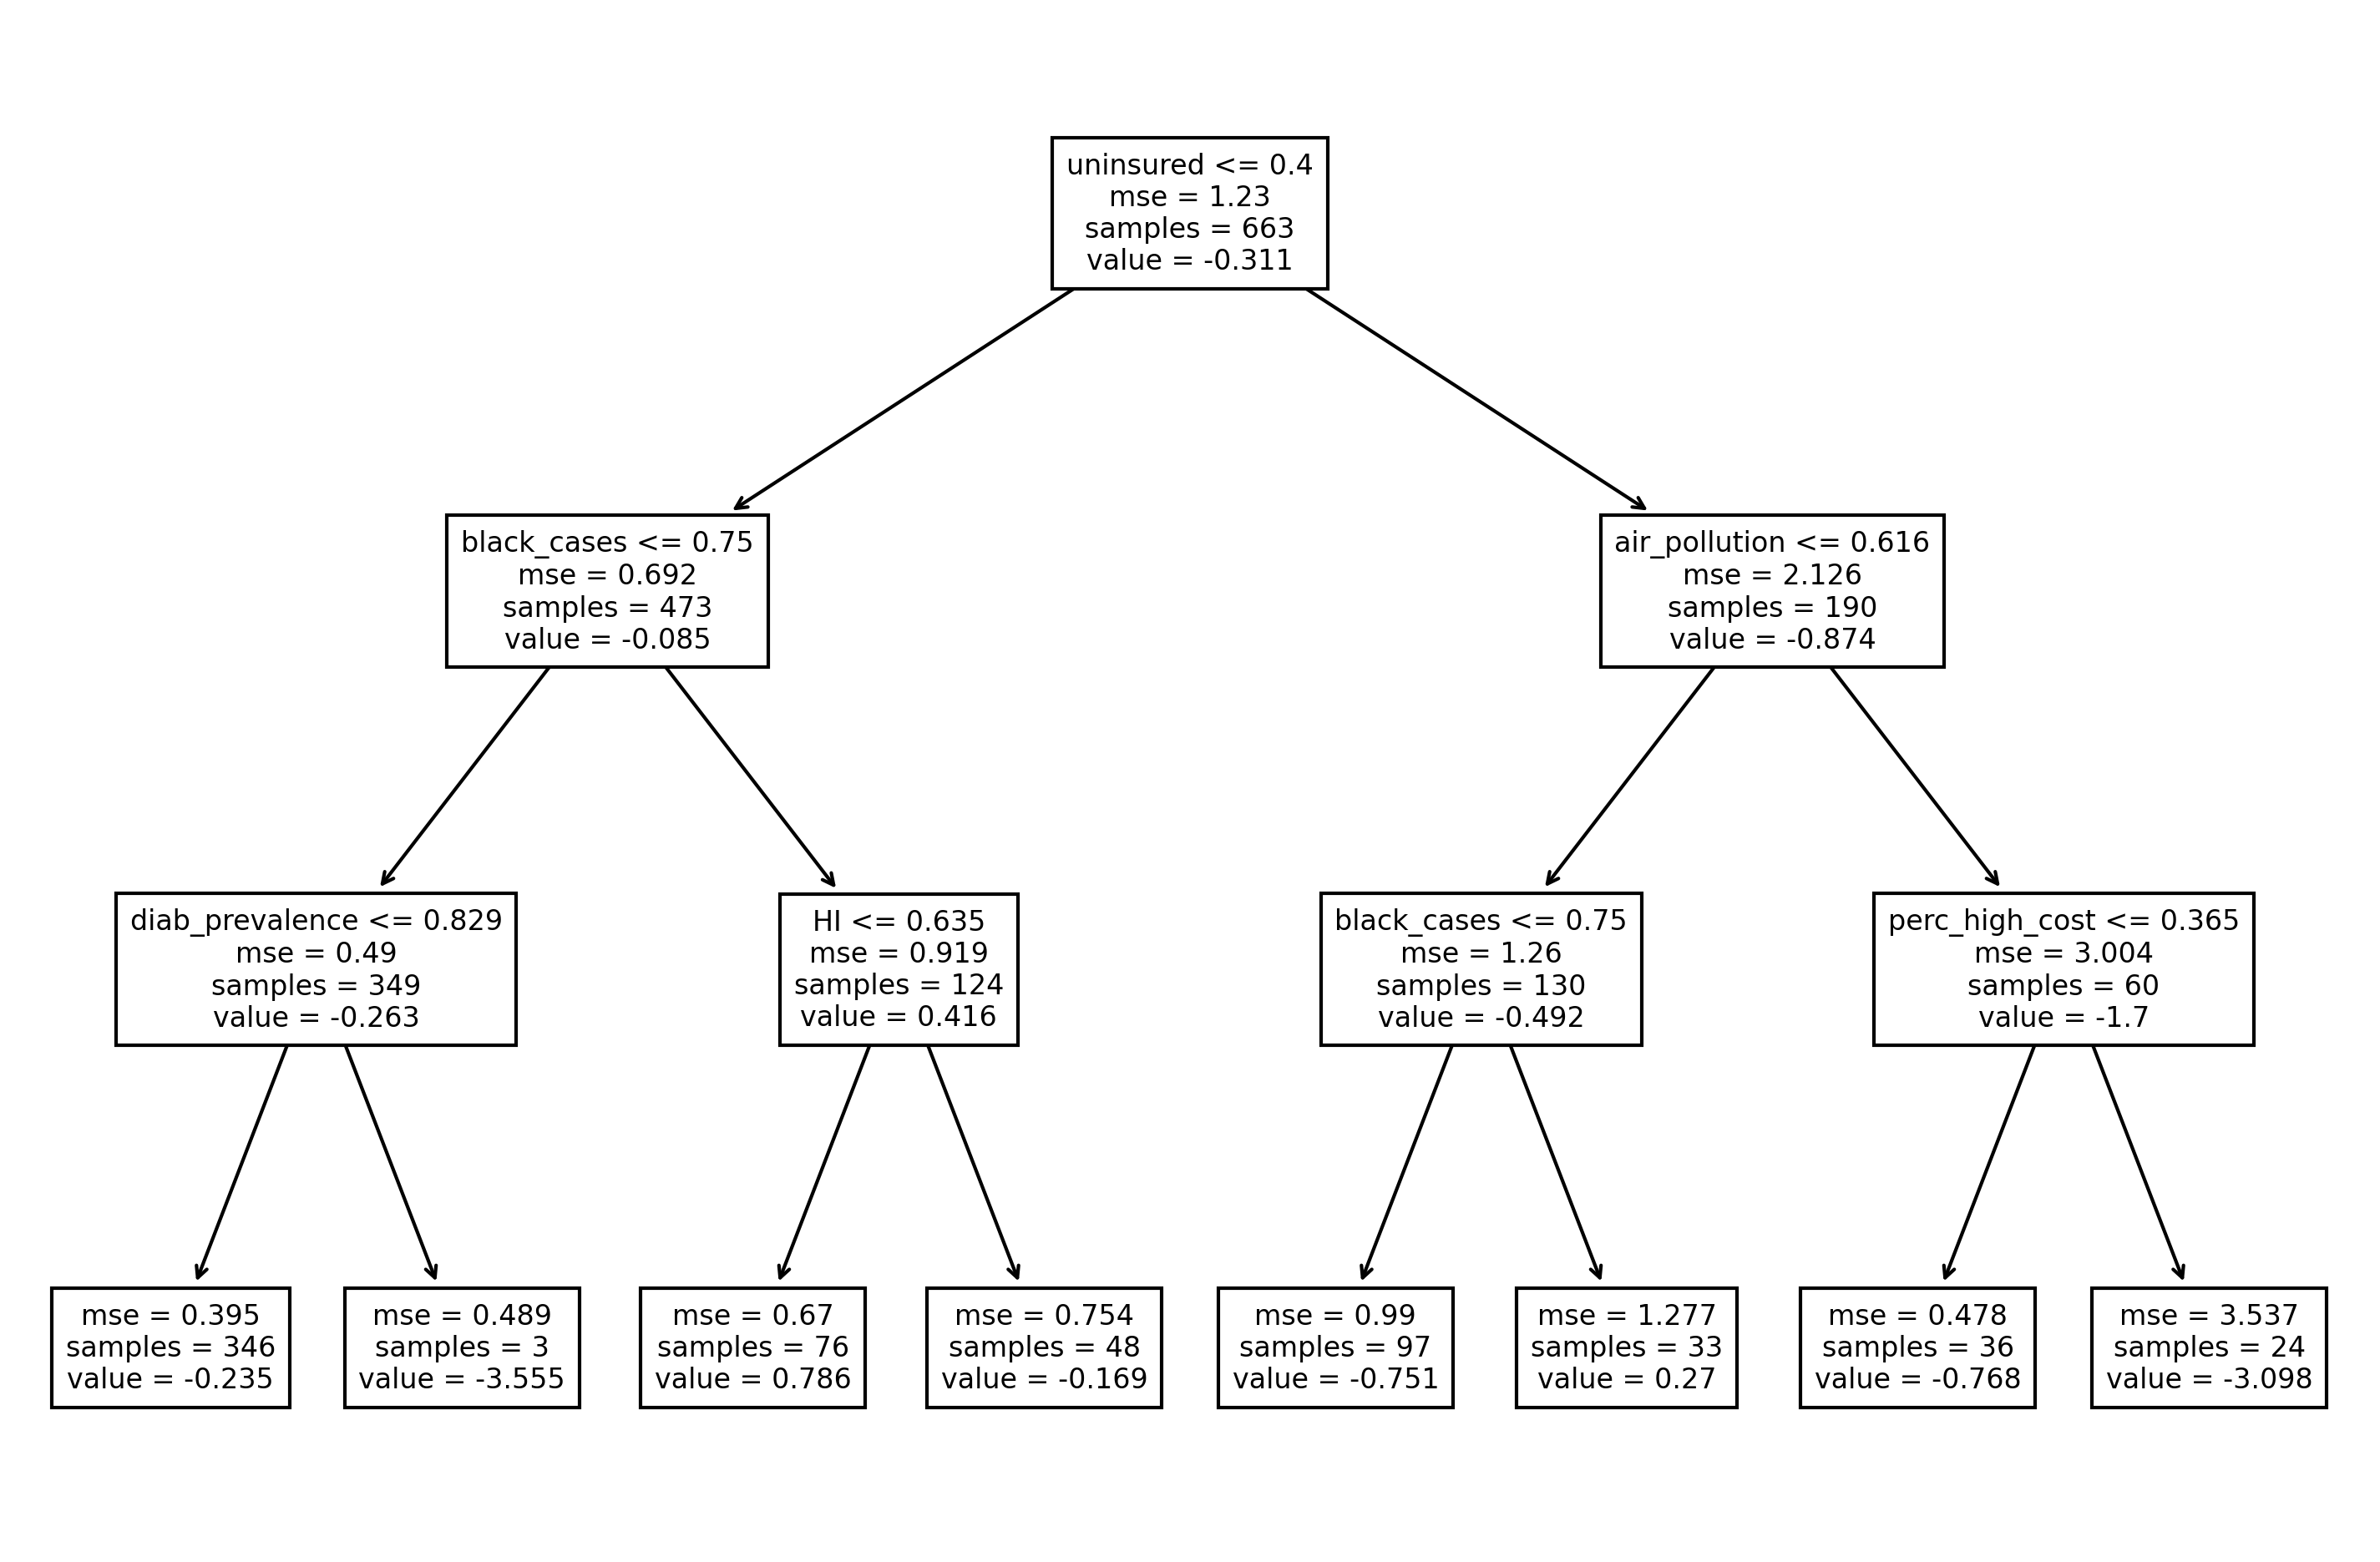

In [71]:
## let's visualize the decision tree's decisions to get some insights
mod = DTree(max_depth=3) # Initialize the modeling object 
mod.fit(train_X,train_y) # Fit the model

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

With the addition of new variables and a few modifications to the preprocessing steps, the mean squared errors are extremely low. While the tree still picked number of uninsured adults as its first variable, a varaible measuring diabetes prevalence in counties is now part of the decision tree. 

#### Bagging

In [72]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Random Forest

In [73]:
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

Let's collect the scores from each model and compare their performance. 

In [74]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores)
collect_scores

,lm,knn,dt,bag,rf
0,0.717203,1.135665,1.553513,0.943062,0.903990
1,0.640231,0.635670,1.096108,0.642391,0.532354
2,0.580625,0.666767,1.280262,0.653205,0.460852
3,0.888941,0.830130,2.307015,0.854412,0.698403
4,0.721092,1.120612,1.209295,0.737430,0.736344


In [75]:
##rename models
collect_scores=collect_scores.rename(columns={'lm':'Linear Model', 'knn':'KNN', 'dt':'Decision Tree', 'bag':'Bagging','rf':'Random Forest'})

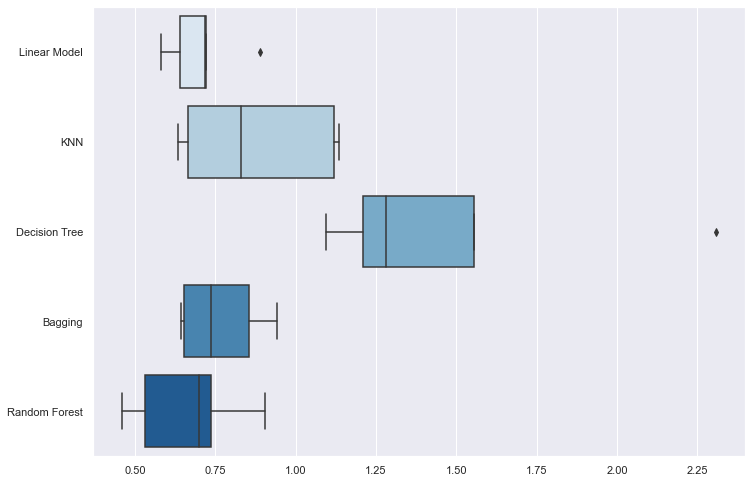

In [76]:
## let's visualize using seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=collect_scores, orient="h", palette="Blues")

Let's use ggplot for visualization, too.

In [77]:
##turn from wide to long for visualization
collect_scores=collect_scores.melt(var_name="Model",value_name="MSE")

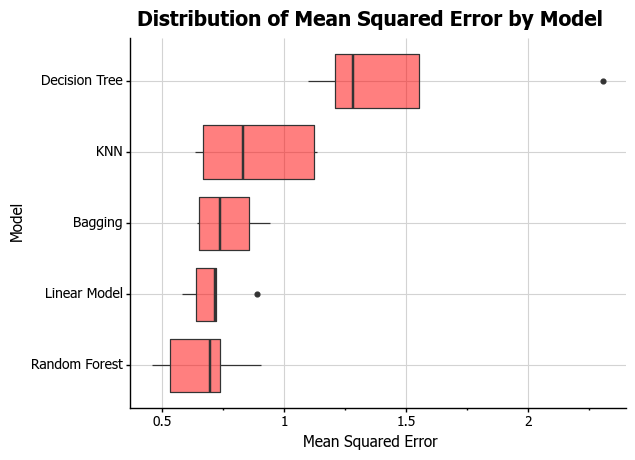

<ggplot: (8773346985954)>

In [78]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
MSE_model_3=(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot(fill="red", alpha=0.5) +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    ##scale_color_brewer(palette="Blues") +
    coord_flip() + theme_classic()+ ggtitle("Distribution of Mean Squared Error by Model")
    + theme(dpi=100,
        legend_position="bottom",
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", 
                                face="bold"),
        text=element_text(family="Tahoma", size=11),
        axis_text_x=element_text(colour="black", size=10),
        axis_text_y=element_text(colour="black", size=10),
    )

)
MSE_model_3
##MSE_model_3.save("MSE_model_3.png")

The mean squared errors are looking better now. In the second attempt, they ranged from 50 to over 200. Here, they range from a little less than 0.5 to almost 3. The Random Forest continues to perform best. The Linear Model is performing better than bagging. Decision Tree continues to trail behind. 

### Tuning: KNN, Decision Tree, and Random Forest 

#### KNN

In [79]:
## try different number of neighbours to see which does best
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [80]:
## wrap tuning parameter in GridSearchCV
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [81]:
## fit model
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [82]:
## see best parameter: how many neighbours?
tune_knn.best_params_

{'n_neighbors': 10}

In [83]:
## what is the best score?
tune_knn.best_score_

-0.9241513014027744

#### Decision Tree 

In [84]:
## try different number for the 'max_depth' parameter
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(20)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [85]:
## fit model
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]},
             scoring='neg_mean_squared_error')

In [86]:
## best parameter
tune_dt.best_params_

{'max_depth': 3}

In [87]:
## what is the best score
tune_dt.best_score_

-1.1271821710240233

#### Random Forest

In [88]:
## try different number for the 'max_depth','n_estimators', and 'max_features' parameters
rf_params = {'max_depth':[5, 10, 20],
             'n_estimators':[100,500,1000],
              'max_features': [10,20,30]}  

In [89]:
## wrap parameters in GridSearchCV
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [90]:
## fit the model
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 20], 'max_features': [10, 20, 30],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [91]:
## best parameters
tune_rf.best_params_

{'max_depth': 20, 'max_features': 30, 'n_estimators': 1000}

In [92]:
## best score
tune_rf.best_score_

-0.6830102620861145

After trying different configurations for the parameters, the Random Forest performed the best. The insights from tuning (i.e,. how to configure parameters) will be incorporated in the modeling pipeline below.

### Modeling Pipeline

In [93]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['cases', 'white_cases', 'black_cases', 'hispanic_cases', 'native_cases',
       'asian_cases', 'TOT_POP', 'WH', 'BA', 'AA', 'IA', 'HI', 'GDP',
       'pov_perc', 'Med_inc', 'Unemployment Rate', 'traffic_vol',
       'house_burden', 'ownership', 'residential_seg', 'food_index',
       'pop_to_phys', 'water_violation', 'air_pollution', 'uninsured',
       'exercise_opp', 'income_ineq', 'high_sch_grad', 'some_college',
       'soc_association', 'perc_high_cost', 'perc_overcrowding', 'perc_plumb',
       'lng_commute', 'life_exp', 'pre_mortality', 'phys_distress',
       'ment_distress', 'diab_prevalence', 'food_insecure', 'food_access',
       'perc_rural', 'crime_violent'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[i for i in range(20)]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[5, 10, 20],
     'model__n_estimators':[100,500,1000],
     'model__max_features': [10,20,30]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['cases',
                                                                          'white_cases',
                                                                          'black_cases',
                                                                          'hispanic_cases',
                                                                          'native_cases',
                                                                          'asian_cases',
                                                                          'TOT_POP',
                                                                          'WH',
            

In [94]:
## what is the best score
search.best_score_

-0.6817700380667372

In [95]:
## best parameter configuration
search.best_params_

{'model': RandomForestRegressor(max_depth=20, max_features=30, n_estimators=1000),
 'model__max_depth': 20,
 'model__max_features': 30,
 'model__n_estimators': 1000}

In [96]:
## which model performed best
search.best_estimator_

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['cases', 'white_cases',
                                                   'black_cases',
                                                   'hispanic_cases',
                                                   'native_cases',
                                                   'asian_cases', 'TOT_POP',
                                                   'WH', 'BA', 'AA', 'IA', 'HI',
                                                   'GDP', 'pov_perc', 'Med_inc',
                                                   'Unemployment Rate',
                                                   'traffic_vol',
                                                   'house_burden', 'ownership',
                                                   'residential_seg',
                                                   'food_index', 'pop_to_phys',
           

In [97]:
## save model and parameter configurations into an object for further exploration below
rf_mod = search.best_estimator_

Let's look at how the model used the variables to make its prediction.

In [98]:
from sklearn.inspection import permutation_importance

In [99]:
## let's shuffle the variables 50 times and see which variables the model relied on and which ones it relied the least on
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=50)

In [100]:
## organize shuffle results as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

In [101]:
## generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

In [102]:
# arrange dataframe in order from most to least important variables 
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,black_cases,0.762427,0.038873,0.684682,0.840173
1,BA,0.333288,0.018882,0.295523,0.371053
2,uninsured,0.174555,0.015577,0.143401,0.205709
3,food_insecure,0.115231,0.006629,0.101973,0.128490
4,perc_high_cost,0.066948,0.005792,0.055364,0.078532
5,air_pollution,0.061052,0.008592,0.043868,0.078237
6,house_burden,0.042769,0.004173,0.034423,0.051114
7,HI,0.040768,0.003518,0.033733,0.047803
8,lng_commute,0.032729,0.003023,0.026682,0.038776
9,ment_distress,0.027250,0.002918,0.021414,0.033086


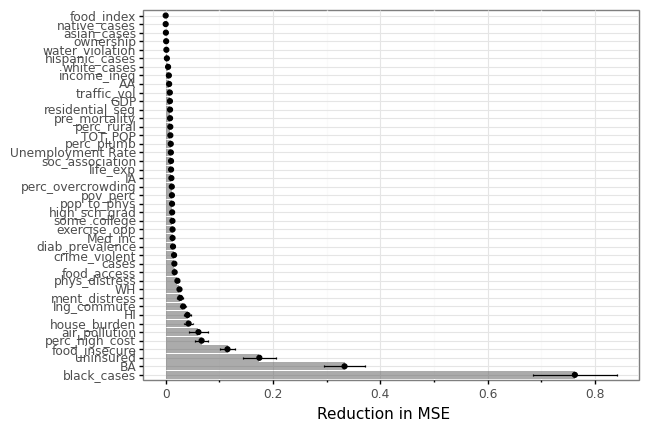

<ggplot: (8773347076003)>

In [103]:
## visualize the dataframe above using ggplot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in MSE",x="")
)

Similar to the previous attempt, the number of black covid-19 cases and black population in a county are the top two variables the model relied on. Uninsured adults continues to retain third place, however two new variables have emerged has part of the five: food insecruity in a county (i.e., percentage of population who lack adequate access to food) and percentage of households with high housing costs.

Let's explore these variables further using partial dependency plots.

In [105]:
## import requred packages
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

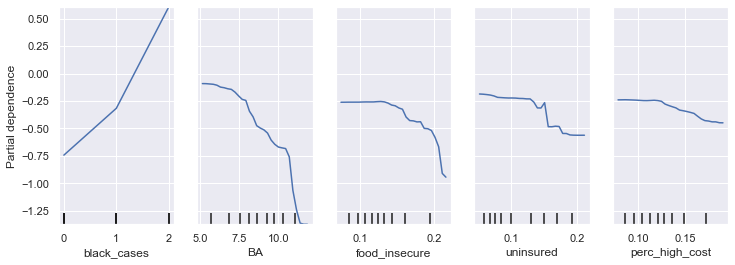

In [106]:
# Target specific features
features = ['black_cases','BA','food_insecure','uninsured','perc_high_cost']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

Like before (attempt 2), almost all the important variables have a negative relationship with the outcome variable. black_cases was a metric used to create the outcome variable; likely why it was selected as the most important variable for the model

Let's use ICE plots to see if there are any heterogenous effects.

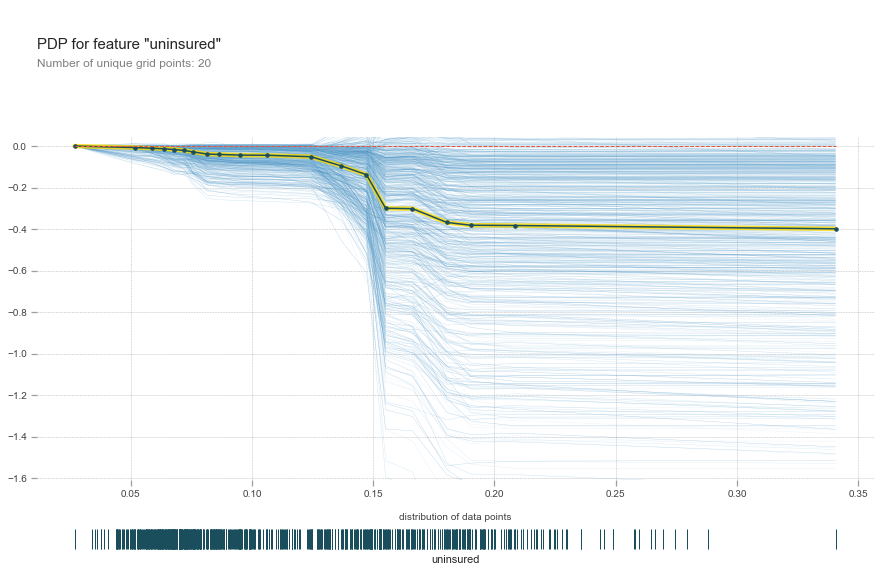

In [120]:
## uninsured
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="uninsured",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'uninsured',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

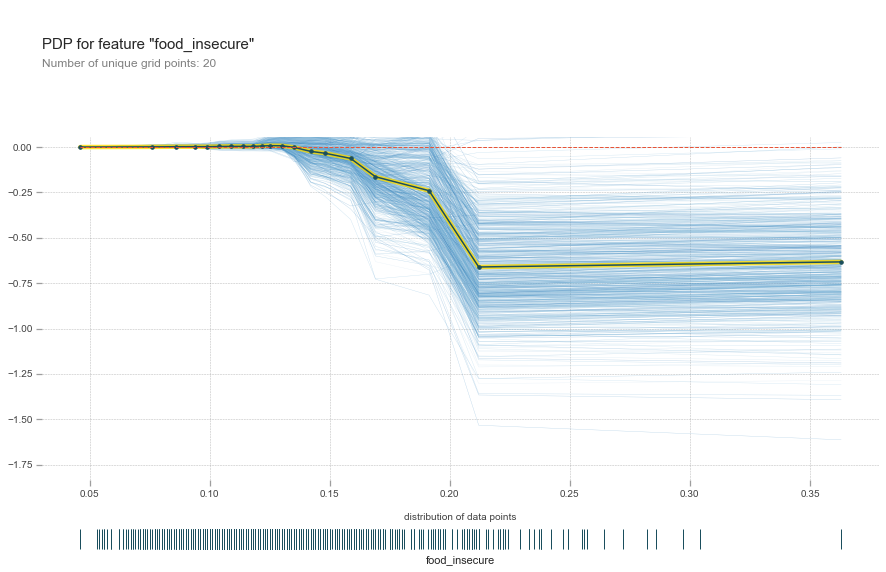

In [121]:
## food insecure
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="food_insecure",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'food_insecure',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

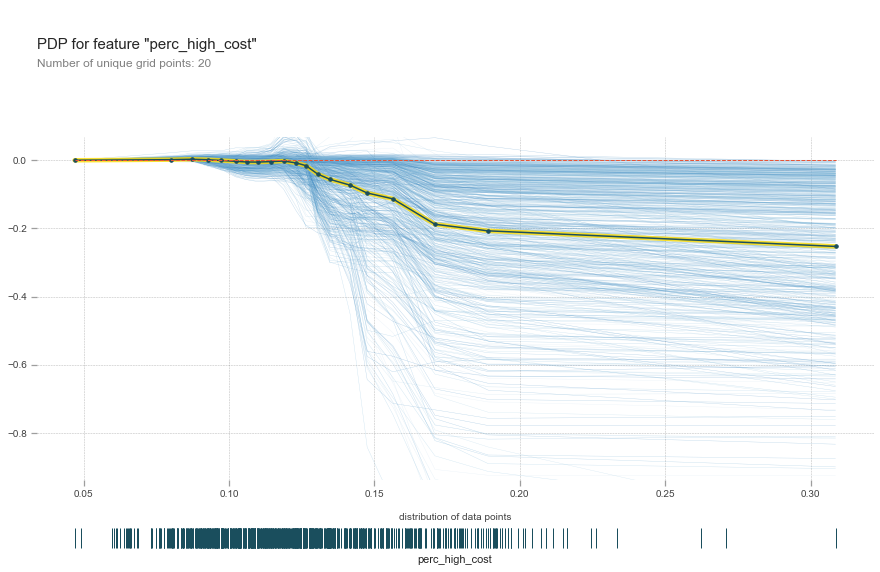

In [122]:
## perc_high_cost
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="perc_high_cost",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'perc_high_cost',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

***Across all three plots, there is a slight indication of heterogeneous effect because some of the blue line shoot slightly past the baseline. Correlations between variables will be considered when selecting features in the next and final attempt. 